In [3]:
import os
import torch
import numpy as np
import pandas as pd
from torchvision import models, transforms
from PIL import Image
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
class ImageClusteringSystem:
    def __init__(self, base_path, csv_path, n_clusters=5, features_path="features.pth"):
        self.base_path = base_path
        self.csv_path = csv_path
        self.n_clusters = n_clusters
        self.features_path = features_path
        
        # Load ResNet50 pre-trained model
        self.model = models.resnet50(pretrained=True)
        self.model.fc = torch.nn.Identity()  # Remove the classification head
        self.model.eval()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        
        # Preprocessing for ResNet50
        self.preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def load_data(self):
        self.df = pd.read_csv(self.csv_path, header=None, names=['image_path', 'category'])
        return self.df

    def extract_features(self, image_path):
        try:
            img = Image.open(os.path.join(self.base_path, image_path)).convert('RGB')
            img_tensor = self.preprocess(img).unsqueeze(0).to(self.device)
            
            with torch.no_grad():
                features = self.model(img_tensor).squeeze().cpu().numpy()
            
            return features
        except Exception as e:
            print(f"Error processing image {image_path}: {str(e)}")
            return None

    def process_all_images(self):
        if os.path.exists(self.features_path):
            print(f"Loading features from {self.features_path}...")
            self.features_array = torch.load(self.features_path)
            print("Features loaded successfully.")

            # Set valid_indices and index_mapping based on the loaded data
            self.valid_indices = list(range(len(self.df)))
            self.index_mapping = {idx: i for i, idx in enumerate(self.valid_indices)}
        else:
            print("Extracting features from images...")
            features_list = []
            valid_indices = []

            for idx, row in self.df.iterrows():
                if idx % 100 == 0:
                    print(f"Processing image {idx}/{len(self.df)}")

                features = self.extract_features(row['image_path'])
                if features is not None:
                    features_list.append(features)
                    valid_indices.append(idx)

            self.features_array = np.array(features_list)
            self.valid_indices = valid_indices
            self.index_mapping = {idx: i for i, idx in enumerate(valid_indices)}

            # Save features to a .pth file
            torch.save(self.features_array, self.features_path)
            print(f"Features saved to {self.features_path}")

        return self.features_array

    def perform_clustering(self):
        print("Performing clustering...")
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=42, n_init='auto')  # Explicit n_init value to avoid warnings
        self.cluster_labels = kmeans.fit_predict(self.features_array)

        self.df['cluster'] = -1
        for idx, cluster_label in zip(self.valid_indices, self.cluster_labels):
            self.df.loc[idx, 'cluster'] = cluster_label

        return self.df


    def save_results(self, output_path):
        self.df.to_csv(output_path, index=False)

    def display_clusters(self, samples_per_cluster=5):
        plt.figure(figsize=(15, 3 * self.n_clusters))

        for cluster in range(self.n_clusters):
            cluster_images = self.df[self.df['cluster'] == cluster]['image_path'].values
            samples = min(samples_per_cluster, len(cluster_images))

            for i in range(samples):
                plt.subplot(self.n_clusters, samples_per_cluster,
                          cluster * samples_per_cluster + i + 1)

                img_path = os.path.join(self.base_path, cluster_images[i])
                img = plt.imread(img_path)
                plt.imshow(img)
                plt.axis('off')
                if i == 0:
                    plt.title(f'Cluster {cluster}')

        plt.tight_layout()
        plt.show()
    def remove_duplicates(self, similarity_threshold=0.99):
        """
        Removes duplicate images based on cosine similarity of features.
        """
        print("Removing duplicates...")
        similarity_matrix = cosine_similarity(self.features_array)
        n = similarity_matrix.shape[0]
        duplicate_indices = set()

        for i in range(n):
            for j in range(i + 1, n):
                if similarity_matrix[i, j] >= similarity_threshold:
                    duplicate_indices.add(self.valid_indices[j])

        # Filter out duplicates
        self.df = self.df.drop(index=list(duplicate_indices)).reset_index(drop=True)

        # Update feature array and indices
        self.features_array = np.delete(self.features_array, 
                                        [self.index_mapping[idx] for idx in duplicate_indices], 
                                        axis=0)
        self.valid_indices = [idx for idx in self.valid_indices if idx not in duplicate_indices]
        self.index_mapping = {idx: i for i, idx in enumerate(self.valid_indices)}

        print(f"Removed {len(duplicate_indices)} duplicate images.")
        return self.df

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading features from /kaggle/input/car-classification-dataset/features.pth...


<ipython-input-3-2a1d578876f8>:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.features_array = torch.load(self.features_path)


Features loaded successfully.
Removing duplicates...
Removed 1322 duplicate images.
Performing clustering...


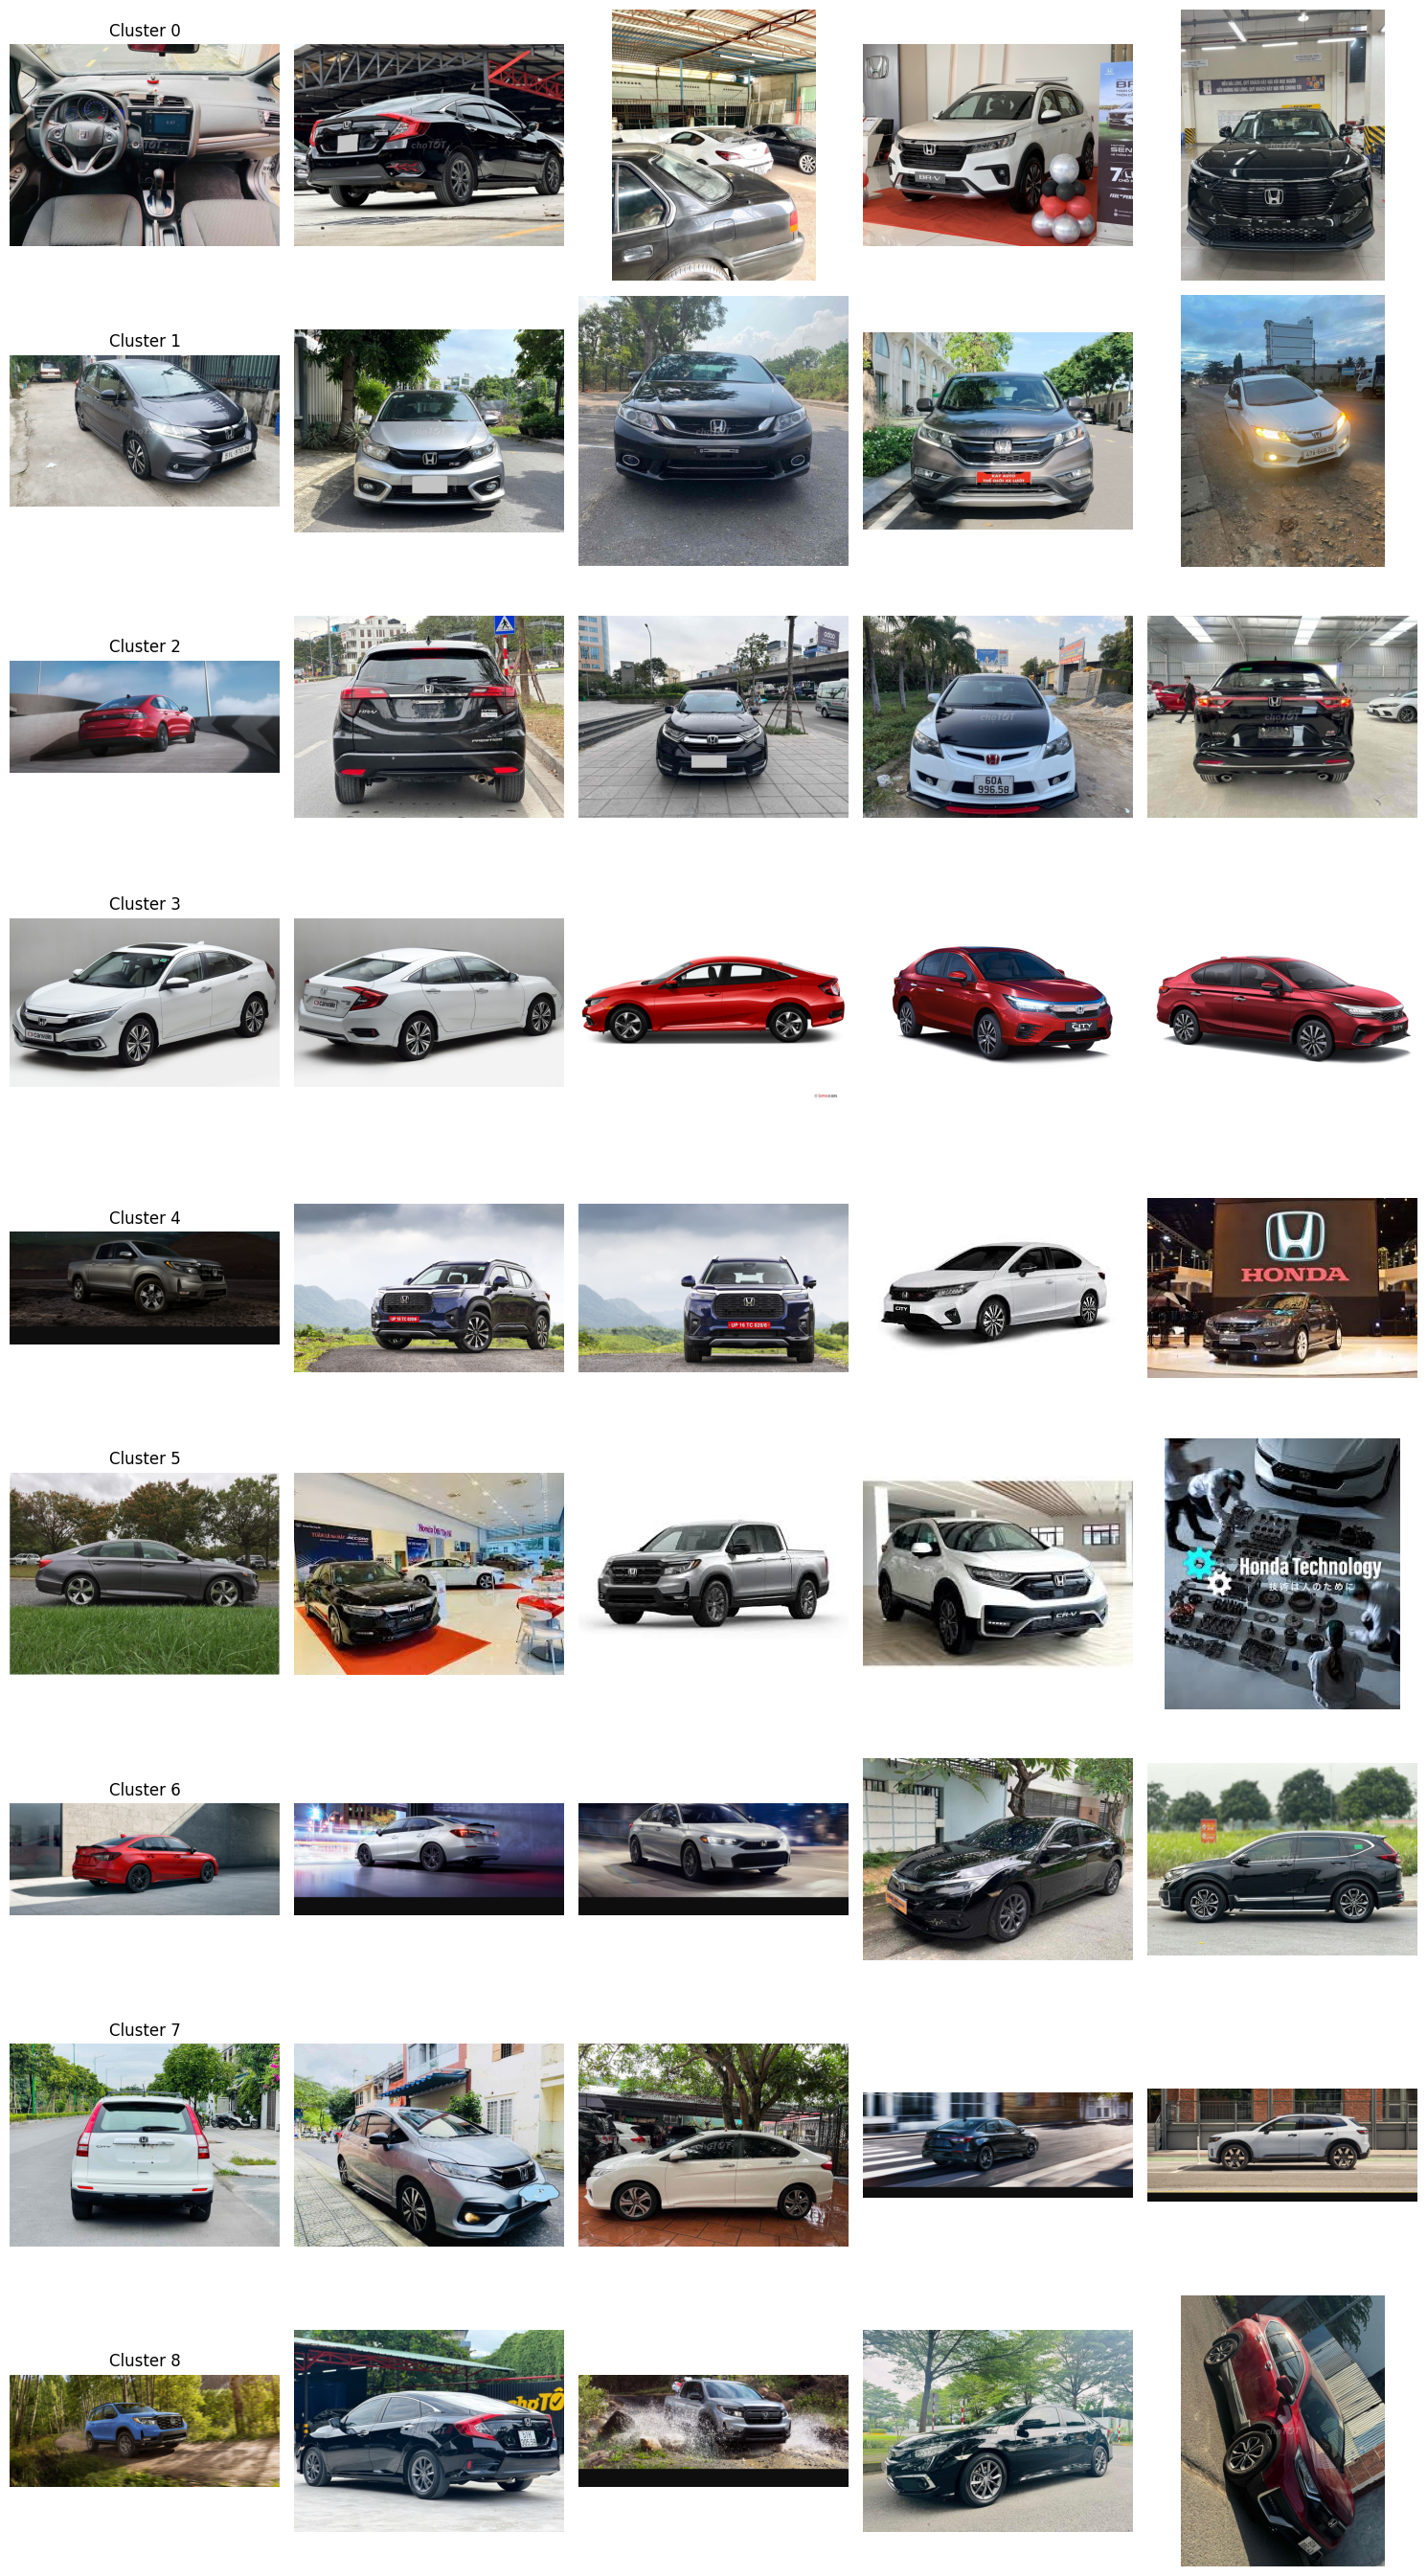

In [4]:
# Example usage
base_path = "/kaggle/input/car-classification-dataset/Public_3/Public_2"
csv_path = "/kaggle/input/car-classification-dataset/CarDataset.csv"
features_path = "/kaggle/input/car-classification-dataset/features.pth"

system = ImageClusteringSystem(base_path, csv_path, n_clusters=9, features_path=features_path)

# Load data
system.load_data()

# Extract features
system.process_all_images()

# Remove duplicate images
system.remove_duplicates(similarity_threshold=0.99)

# Perform clustering
results_df = system.perform_clustering()

# Save results
system.save_results("clustering_results.csv")

# Display clusters
system.display_clusters()
